In [1]:
from tree.base import WeightedDecisionTree
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


In [14]:
X, y = make_classification(
n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)
X = pd.DataFrame(X)
y = pd.Series(y, dtype = 'float')

In [15]:
# replace all zeros with -1 in y

y = y.replace(0, -1)
y = y*(1/len(y))
y

0     0.01
1     0.01
2    -0.01
3    -0.01
4    -0.01
      ... 
95    0.01
96   -0.01
97   -0.01
98    0.01
99   -0.01
Length: 100, dtype: float64

In [16]:
# X['Weight'] = [1/len(X)]*len(X)
# print(X.head())

In [17]:
X_train, X_test, y_train, y_test = pd.DataFrame(X[:int(0.7*len(X))]), pd.DataFrame(X[int(0.7*len(X)):]), pd.Series(y[:int(0.7*len(y))], dtype = 'category'), pd.Series(y[int(0.7*len(y)):], dtype = 'category')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 2) (30, 2) (70,) (30,)


In [18]:
y.head


<bound method NDFrame.head of 0     0.01
1     0.01
2    -0.01
3    -0.01
4    -0.01
      ... 
95    0.01
96   -0.01
97   -0.01
98    0.01
99   -0.01
Length: 100, dtype: float64>

In [41]:
def weighted_entropy(Y: pd.Series) -> float:
    """
    Function to calculate the entropy
    """
    p_positive = sum(Y[Y>=0])/len(Y)
    p_negative = -1*(sum(Y[Y<0])/len(Y))

    print(p_positive, p_negative)
    entropy = -p_positive * np.log2(p_positive) - p_negative * np.log2(p_negative)

    return entropy

In [42]:
S = pd.Series([0.1, 0.1, -0.1, -0.1, -0.3, 0.3])

weighted_entropy(S)

0.08333333333333333 0.08333333333333333


0.5974937501201927

In [84]:
df = pd.DataFrame({'y':['a', 'b', 'a', 'a', 'b'], 'w': [1, 1, 2, 2, 2]})


In [90]:
df2 = pd.DataFrame({'y':['a', 'b', 'a', 'a', 'b'], 'w': [1, 1, 2, 2, 2], 'b': None})
df2

,y,w,b
0,a,1,None
1,b,1,None
2,a,2,None
3,a,2,None
4,b,2,None


In [86]:

class_counter = df.groupby('y').sum()
class_counter

,w
y,
a,5
b,3


In [87]:
print(1 - (class_counter['w']**2).sum()/(df['w'].sum()**2))

0.46875


In [88]:
def gini_index(Y: pd.Series, sample_wieghts: pd.Series = None) -> float:
    """
    Function to calculate the gini index
    """
    if len(Y) == 0:
        return 0
    
    if sample_wieghts is None:
        sample_wieghts = pd.Series([1]*len(Y))
        
    total_weights = sample_wieghts.sum()

    df = pd.DataFrame({'y':Y, 'w': sample_wieghts})
    class_counter = df.groupby('y').sum()
    gini = 1 - (class_counter['w']**2).sum()/(total_weights**2)

    return gini

In [89]:
gini_index(df['y'],df['w'])

0.46875

In [91]:
def avg_gini_coefficient(Y: pd.Series, X: pd.Series, wt: pd.Series = None) -> (float,float):
    """
    Function to calculate the average gini coefficient
    """
    if len(Y) == 0:
        return (0, None)

    if wt is None:
        wt = pd.Series([1]*len(Y))
    
    #--- discrete input - discrete output -----------------------
    if X.dtype == "object" or X.dtype == "category":
        X = X.astype('category')
        # create the dictionary of each input category
        class_count = X.value_counts()

        weighted_gini = 0
        total_weight = wt.sum()

        for c in class_count.index:
            # calculate the gini index of the class
            gini_index_of_Xc = gini_index(Y[X == c], wt[X == c] ) 
            # calculate the weight of the class
            class_weight = wt[X == c].sum()
            # calculate the weighted gini index
            weighted_gini += (class_weight/total_weight) * gini_index_of_Xc
        return (weighted_gini, None)      

    #--- continuous input - discrete output ---------------------
    else:
        X = X.astype('float')
        # TODO sort Y and attr by attr 
        df = pd.DataFrame({'attr': X, 'Y': Y, 'wt': wt})
        df = df.sort_values(by=['attr'])

        if len(Y) == 1:
            return (0,None)

        min_gini = 1
        split_value = df['attr'].iloc[0]
        gini_of_y = gini_index(df['Y'], df['wt'])

        for y in range(len(Y)-1):
            
            # if df['Y'].iloc[y] == df['Y'].iloc[y+1]:
            #     continue
            if df['attr'].iloc[y] == df['attr'].iloc[y+1]:
                continue
            
            split = (df['attr'].iloc[y] + df['attr'].iloc[y+1])/2
            
            # Calculate the gini index of the left and right splits
            gi_of_lt_split = gini_index(df['Y'][df['attr'] <= split], df['wt'][df['attr'] <= split])
            gi_of_gt_split = gini_index(df['Y'][df['attr'] > split], df['wt'][df['attr'] > split])

            # Calculate the weights
            class_wieghts_ls_split = df['wt'][df['attr'] <= split].sum()
            class_wieghts_gt_split = df['wt'][df['attr'] > split].sum()
            total_weight = df['wt'].sum() 

            weighted_gini = 0
            weighted_gini += (class_wieghts_ls_split/total_weight * gi_of_lt_split)
            weighted_gini += (class_wieghts_gt_split/total_weight * gi_of_gt_split)

            # findig the minimum gini index
            if weighted_gini < min_gini:
                min_gini = weighted_gini
                split_value = split
            
        return (min_gini , split_value)



In [94]:
y = pd.Series(['a', 'a', 'b', 'b', 'a', 'a', 'b'])
X = pd.Series([1, 2, 3, 4, 5, 6, 7])
wt = pd.Series([1, 2, 1, 2, 1, 4, 1])

avg_gini_coefficient(y, X, wt)

(0.3400236127508855, 6.5)

In [110]:
def entropy(Y: pd.Series, wt: pd.Series = None) -> float:

    # class_counter = dict() 
    # for y in Y:
    #     class_counter[y] = class_counter.get(y,0) + 1
    if wt is None:
        wt = pd.Series([1]*len(Y))

    class_counter = Y.value_counts()
    total_weight = wt.sum()

    df = pd.DataFrame({'y':Y, 'w': wt})
    entropy = 0

    for y in class_counter.index:
        p = df['w'][df['y'] == y].sum()/total_weight
        entropy -= p * np.log2(p)

    return entropy

In [113]:
y = pd.Series(['a', 'a', 'a', 'a', 'a', 'a', 'b', 'a'])
wt = pd.Series([1, 1, 2, 2, 3, 11, 1])

entropy(y, wt)

0.2761954276479391

In [118]:
def information_gain(Y: pd.Series, attr: pd.Series, wt: pd.Series = None) -> (float, float):
    """
    Function to calculate the information gain
    """
    if len(Y) == 0:
        return 0, None
    if wt is None:
        wt = pd.Series([1]*len(Y))

    total_weight = wt.sum()

    #--------------Discrete input - discrete output--------------------------
    if attr.dtype == "object" or attr.dtype == "category":
        attr = attr.astype('category')
        # attr = attr.cat.codes
        class_count = attr.value_counts()
        gain = entropy(Y, wt)
        # total_weight = df['wt'].sum()
        for c in class_count.index:
            class_weight = wt[X == c].sum()
            gain -= (class_weight/total_weight) * entropy(Y[attr == c], wt[attr == c])

        return (gain, None)
    
    #------------------ Continous input - discrete output ------------------
    else:
        attr = attr.astype('float')
        # gain = entropy(Y)

        # TODO sort Y and attr by attr 
        df = pd.DataFrame({'attr': attr, 'Y': Y, 'wt': wt})
        df = df.sort_values(by=['attr'])

        # df['attr'].astype('float')
        if len(Y) == 1:
            return 0, None

        max_gain = 0
        split_value = df['attr'].iloc[0]
        gain_of_y = entropy(df['Y'], df['wt'])

        for y in range(len(Y)-1):
            # if df['Y'].iloc[y] == df['Y'].iloc[y+1]:
            #     continue
            if df['attr'].iloc[y] == df['attr'].iloc[y+1]:
                continue
            split = (df['attr'].iloc[y] + df['attr'].iloc[y+1])/2

            # entropy of the left and right splits
            entropy_lt_split = entropy(df['Y'][df['attr'] <= split], df['wt'][df['attr'] <= split])
            entropy_gt_split = entropy(df['Y'][df['attr'] > split], df['wt'][df['attr'] > split])

            # Calculate the weights
            class_wieghts_ls_split = df['wt'][df['attr'] <= split].sum()
            class_wieghts_gt_split = df['wt'][df['attr'] > split].sum()

            gain = gain_of_y
            gain -= (class_wieghts_ls_split/total_weight) * entropy_lt_split
            gain -= (class_wieghts_gt_split/total_weight) * entropy_gt_split

            if gain > max_gain:
                max_gain = gain
                split_value = split
        return max_gain , split_value
        
        # for c in attr.unique():
        #     gain -= (len(Y[attr == c])/len(Y)) * entropy(Y[attr == c])
        # return gain


In [122]:
x = pd.Series([1, 2, 3, 4, 5, 6, 7])
y = pd.Series(['a', 'a', 'b', 'b', 'a', 'a', 'b'])
wt = pd.Series([1, 1, 1, 1, 10, 10, 1])
information_gain(y, x, wt)

(0.13735670606309552, 4.5)

In [123]:
def reduction_in_variance(Y: pd.Series, attr: pd.Series, wt: pd.Series = None) -> (float, float):

    if len(Y) <= 1:
        return 0, None
    if wt is None:
        wt = pd.Series([1]*len(Y))
    total_weight = wt.sum()

    # For discrete input data - continuous output data
    if attr.dtype == "object" or attr.dtype == "category":
        attr = attr.astype('category')
        class_count = attr.value_counts()
        gain = np.var(Y)
        for c in class_count.index:
            y_col = Y[attr == c]
            if len(y_col) == 0:
                continue
            class_weight = wt[attr == c].sum()

            gain -= (class_weight/total_weight) * np.var(y_col)
        return gain, None
    
    # For continuous input data - continuous output data
    
    else:
        # TODO sort Y and attr by attr 
        df = pd.DataFrame({'attr': attr, 'Y': Y, 'wt': wt})
        df = df.sort_values(by=['attr'])
        df['attr'].astype('float')

        split_value = df['attr'].iloc[0]
        if len(Y) == 1:
            return 0, split_value

        max_gain = 0
        gain_of_y = np.var(df['Y'])
        for y in range(len(Y)-1):
            # if df['Y'].iloc[y] == df['Y'].iloc[y+1]:
            #     continue
            if df['attr'].iloc[y] == df['attr'].iloc[y+1]:
                continue
            split = (df['attr'].iloc[y] + df['attr'].iloc[y+1])/2
            # variance of the left and right splits
            variance_lt_split = np.var(df['Y'][df['attr'] <= split])
            variance_gt_split = np.var(df['Y'][df['attr'] > split])

            # Calculate the weights
            class_wieghts_ls_split = df['wt'][df['attr'] <= split].sum()
            class_wieghts_gt_split = df['wt'][df['attr'] > split].sum()


            gain = gain_of_y 
            gain -= (class_wieghts_ls_split/total_weight) * variance_lt_split
            gain -= (class_wieghts_gt_split/total_weight) * variance_gt_split
            
            if gain > max_gain:
                max_gain = gain
                split_value = split
        return max_gain , split_value

In [124]:
x = pd.Series([1, 2, 3, 4, 5, 6, 7])
y = pd.Series([1, 2, 3, 4, 5, 6, 7])
wt = pd.Series([1, 1, 1, 1, 10, 10, 1])
reduction_in_variance(y, x, wt)

(3.2399999999999998, 4.5)

In [128]:
y = pd.Series([0,1,0,0,1,1,1,0,0])
w = pd.Series([1,1,1,1,1,1,1,1,1])

df = pd.DataFrame({'y': y, 'w': w})

class_counter = y.value_counts()
class_counter

0    5
1    4
dtype: int64

In [132]:
for c in class_counter.index:
    print(df['w'][df['y'] == c].sum())

5
4


In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

array([1.        , 0.93333333, 1.        , 0.93333333, 0.93333333,
       0.86666667, 0.93333333, 1.        , 1.        , 1.        ])

In [6]:
clf.fit(iris.data, iris.target)
r = clf.apply(iris.data)

In [5]:
iris.data.shape


(150, 4)

In [8]:
r

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5, 15,  5,  5,  5,  5,  5,  5, 10,  5,  5,  5,  5,  5, 10,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5, 16, 16,
       16, 16, 16, 16,  6, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        8, 16, 16, 16, 16, 16, 16, 14, 16, 16, 11, 16, 16, 16,  8,  8, 16,
       16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16])

In [21]:
# find unique values in r
import numpy as np
np.unique(r)

array([ 1,  5,  6,  8, 10, 11, 14, 15, 16])

In [9]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
clf.apply(iris.data[100:101])

array([16])

In [14]:
a = clf.decision_path(iris.data[100:101])

In [16]:
print(a)

  (0, 0)	1
  (0, 2)	1
  (0, 12)	1
  (0, 16)	1


In [17]:
from sklearn import tree

[Text(0.5, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(0.4230769230769231, 0.75, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(0.5769230769230769, 0.75, 'x[3] <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(0.3076923076923077, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(0.15384615384615385, 0.4166666666666667, 'x[3] <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(0.07692307692307693, 0.25, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]'),
 Text(0.23076923076923078, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.46153846153846156, 0.4166666666666667, 'x[3] <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(0.38461538461538464, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.5384615384615384, 0.25, 'x[2] <= 5.45\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 1]'),
 Text(0.46153846153846156, 0.08333333333333333, 'gini 

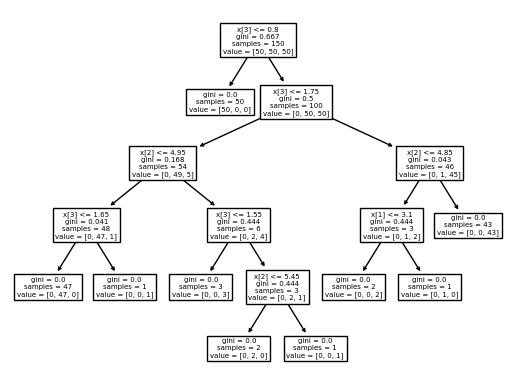

In [18]:
tree.plot_tree(clf)

In [22]:
np.unique(r)

array([ 1,  5,  6,  8, 10, 11, 14, 15, 16])

In [23]:
clf.predict(iris.data)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [29]:
y_hat = clf.predict(iris.data)
y_hat - iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [30]:
# find the average of iris.target
y = iris.target
y_avg = np.mean(y)
y_avg

1.0

In [31]:
# residual of y from y_avg
y_res = y - y_avg

In [32]:
y_res

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [33]:
clf2 = DecisionTreeClassifier(random_state=0, max_depth=1)
clf2.fit(iris.data, y_res)
y_hat2 = clf2.predict(iris.data)

In [34]:
y_hat2

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [41]:
a = [1,2,3,4,5,6,7,8,9,10]
import math
math.modf(a)

TypeError: must be real number, not list

In [43]:
import statistics as stat
stat.mode(a)

1

In [46]:
stat.mean(a)

5.5

In [4]:
import pandas as pd
a = pd.Series([1,2,3,3,2,6,1,1,2,2])
b = pd.Series([3,1,2,5,2,3,4,5,1,2])

a*b

0     3
1     2
2     6
3    15
4     4
5    18
6     4
7     5
8     2
9     4
dtype: int64

In [5]:
df = pd.DataFrame({'a': a, 'b': b})
df

,a,b
0,1,3
1,2,1
2,3,2
3,3,5
4,2,2
5,6,3
6,1,4
7,1,5
8,2,1
9,2,2


In [6]:
grouped = df.groupby(['a']).sum()

In [7]:
grouped

,b
a,
1,12
2,6
3,7
6,3


In [8]:
grouped.mean()

b    7.0
dtype: float64

In [11]:
# find the weighted average of a with b as weights  
# weighted average of a
import numpy as np
np.average(a, weights=b)


2.25

In [12]:
type(a)

pandas.core.series.Series

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from metrics import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
# from ensemble.gradientBoosted import GradientBoostedClassifier
from tree.base import DecisionTree

# Or use sklearn decision tree

########### GradientBoostedClassifier ###################

from sklearn.datasets import make_regression



In [74]:
X, y= make_regression(
       n_features=3,
       n_informative=3,
       noise=10,
       tail_strength=10,
       random_state=42,
       n_samples=20
   )

X.shape, y.shape
print(type(X), type(y))
N = 10
P = 3
X1 = pd.DataFrame({i:pd.Series(np.random.randint(P, size = N), dtype="category") for i in range(5)})
y1 = pd.Series(np.random.randn(N))

X1 = np.random.randint(P, size = (N,5))
y1 = np.random.randn(N)
X1.shape, y1.shape



<class 'numpy.ndarray'> <class 'numpy.ndarray'>


((10, 5), (10,))

In [75]:
X1

array([[0, 0, 2, 1, 1],
       [1, 0, 0, 0, 0],
       [1, 2, 0, 0, 1],
       [2, 2, 1, 1, 2],
       [0, 2, 1, 0, 0],
       [1, 1, 1, 2, 2],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 1, 1],
       [2, 1, 2, 1, 1],
       [1, 2, 2, 0, 2]])

In [76]:
y1

array([ 0.17396633,  0.90787195, -0.00879056,  0.4514112 ,  0.81585162,
        0.56675593,  0.28598017,  1.78311284,  1.2419706 , -0.08576317])

In [83]:
from ensemble.gradientBoosted import GradientBoostedRegressor
GBreg = GradientBoostedRegressor(base_estimator=DecisionTreeRegressor, n_estimators=100, learning_rate=0.1)
GBreg.fit(X, y)
y_hat = GBreg.predict(X)
print(y-y_hat)
print("MSE: ", mean_squared_error(y, y_hat))
print("R2: ", r2_score(y, y_hat))

[ 47.73098655 -54.3326036    6.93473651  19.88119015 -34.06948282
  22.3347076   12.71717716  19.31957126 -56.37266498 -29.34911225
   7.61649728  34.36479132 -64.2632075   -9.44186611  50.77761194
  11.51890094  19.64153141 -40.76711778   8.12515456  27.63319835]
MSE:  1147.6844578694381
R2:  0.1899999999825842


-----------------------------
Tree Number: 1
-----------------------------
|--- feature_0 <= 5.75
|   |--- feature_1 <= 3.05
|   |   |--- class: 1
|   |--- feature_1 >  3.05
|   |   |--- class: 0
|--- feature_0 >  5.75
|   |--- feature_0 <= 7.05
|   |   |--- class: 2
|   |--- feature_0 >  7.05
|   |   |--- class: 2

-----------------------------
Tree Number: 2
-----------------------------
|--- feature_0 <= 5.75
|   |--- feature_1 <= 2.85
|   |   |--- class: 2
|   |--- feature_1 >  2.85
|   |   |--- class: 0
|--- feature_0 >  5.75
|   |--- feature_0 <= 7.05
|   |   |--- class: 1
|   |--- feature_0 >  7.05
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))


-----------------------------
Tree Number: 3
-----------------------------
|--- feature_0 <= 5.85
|   |--- feature_0 <= 4.85
|   |   |--- class: 0
|   |--- feature_0 >  4.85
|   |   |--- class: 1
|--- feature_0 >  5.85
|   |--- feature_0 <= 6.25
|   |   |--- class: 2
|   |--- feature_0 >  6.25
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:247: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=cmap, edgecolor='black', s=30,label="Class: "+str(y_label))


Criteria : entropy
sklearn accuracy:  0.76
Accuracy:  0.76
-----------------------------
Tree Number: 1
-----------------------------
|--- feature_1 <= 4.75
|   |--- feature_1 <= 2.45
|   |   |--- class: 0
|   |--- feature_1 >  2.45
|   |   |--- class: 1
|--- feature_1 >  4.75
|   |--- feature_1 <= 5.15
|   |   |--- class: 2
|   |--- feature_1 >  5.15
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))


-----------------------------
Tree Number: 2
-----------------------------
|--- feature_0 <= 4.95
|   |--- feature_1 <= 3.90
|   |   |--- class: 0
|   |--- feature_1 >  3.90
|   |   |--- class: 2
|--- feature_0 >  4.95
|   |--- feature_1 <= 5.15
|   |   |--- class: 1
|   |--- feature_1 >  5.15
|   |   |--- class: 2

-----------------------------
Tree Number: 3
-----------------------------
|--- feature_1 <= 2.45
|   |--- class: 0
|--- feature_1 >  2.45
|   |--- feature_1 <= 4.45
|   |   |--- class: 1
|   |--- feature_1 >  4.45
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:247: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=cmap, edgecolor='black', s=30,label="Class: "+str(y_label))


Criteria : entropy
sklearn accuracy:  0.96
Accuracy:  0.96
-----------------------------
Tree Number: 1
-----------------------------
|--- feature_0 <= 4.75
|   |--- feature_0 <= 2.45
|   |   |--- class: 0
|   |--- feature_0 >  2.45
|   |   |--- class: 1
|--- feature_0 >  4.75
|   |--- feature_1 <= 1.75
|   |   |--- class: 2
|   |--- feature_1 >  1.75
|   |   |--- class: 2

-----------------------------
Tree Number: 2
-----------------------------
|--- feature_0 <= 4.55
|   |--- feature_1 <= 1.65
|   |   |--- class: 1
|   |--- feature_1 >  1.65
|   |   |--- class: 2
|--- feature_0 >  4.55
|   |--- feature_1 <= 1.85
|   |   |--- class: 1
|   |--- feature_1 >  1.85
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=ListedColormap(["r", "g", "b"]), edgecolor='black', s=20,label="Class: "+str(y_label))
/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:232: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1[i].scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],

-----------------------------
Tree Number: 3
-----------------------------
|--- feature_1 <= 0.80
|   |--- class: 0
|--- feature_1 >  0.80
|   |--- feature_0 <= 5.15
|   |   |--- class: 2
|   |--- feature_0 >  5.15
|   |   |--- class: 2



/home/mc_ultron/github-classroom/ES654/es654-spring2023-assignment2-siddhesh_dosi-ritesh/ensemble/ADABoost.py:247: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(X[idx].iloc[:, 0], X[idx].iloc[:, 1], c=color[id],cmap=cmap, edgecolor='black', s=30,label="Class: "+str(y_label))


Criteria : entropy
sklearn accuracy:  0.96
Accuracy:  0.96
0.6266666666666667
0.9533333333333334
0.96
sklearn precision:  1.0
Precision:  1.0
sklearn recall:  1.0
Recall:  1.0
sklearn precision:  0.9074074074074074
Precision:  0.9074074074074074
sklearn recall:  0.98
Recall:  0.98
sklearn precision:  0.9782608695652174
Precision:  0.9782608695652174
sklearn recall:  0.9
Recall:  0.9


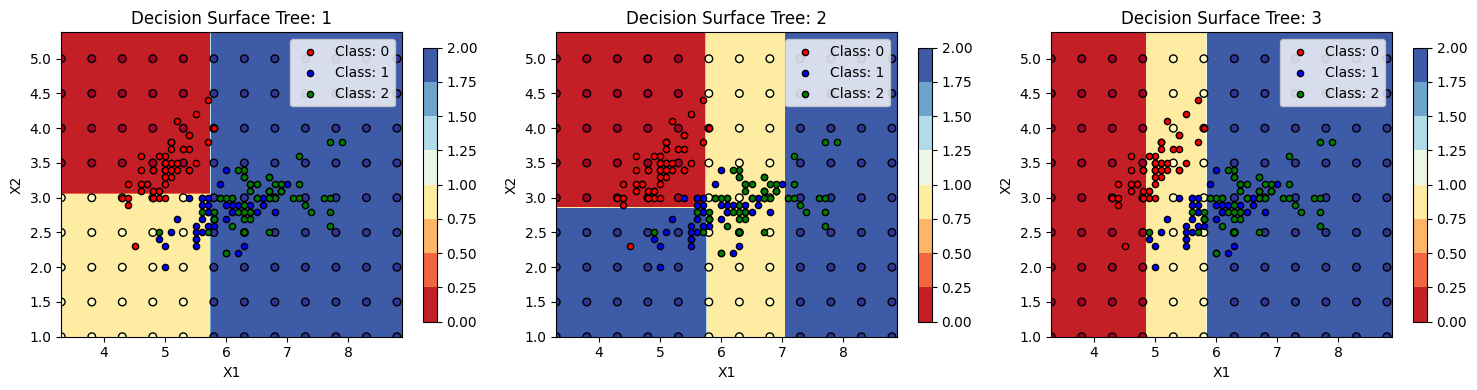

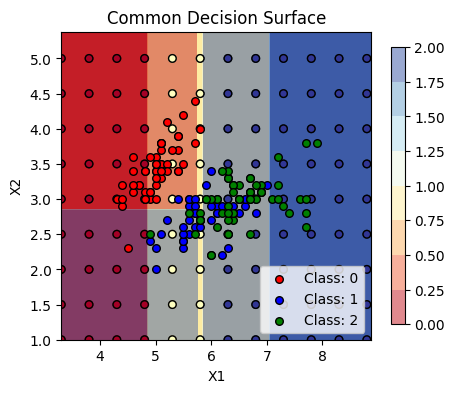

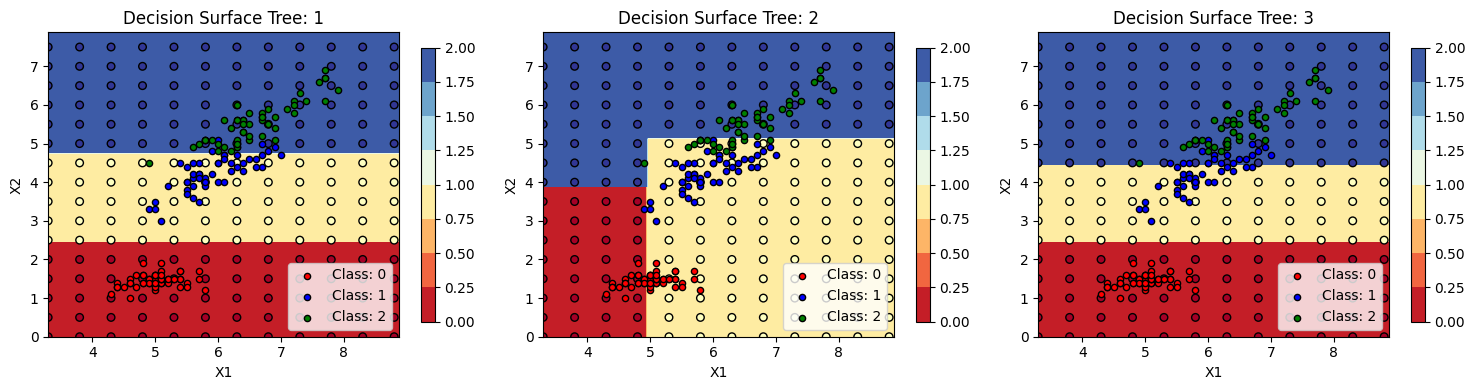

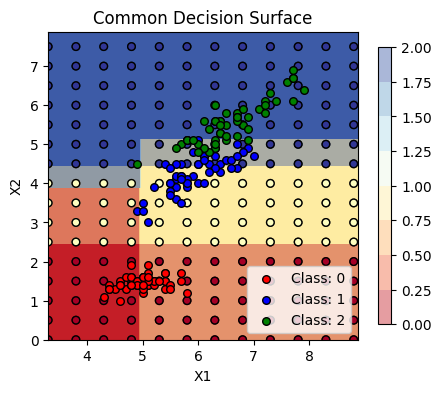

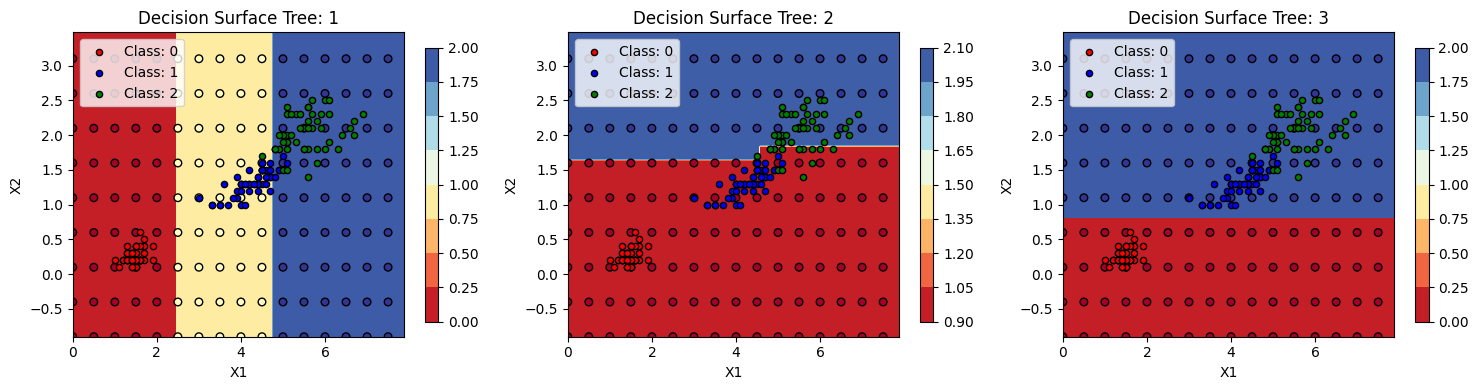

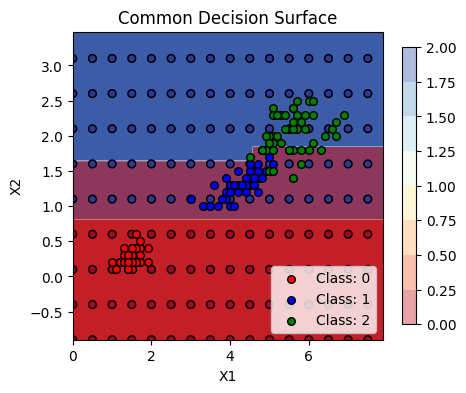

: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from metrics import *

from ensemble.ADABoost import AdaBoostClassifier
#from tree.base import DecisionTree
from sklearn.tree import DecisionTreeClassifier
# Or you could import sklearn DecisionTree
from sklearn.datasets import load_iris
np.random.seed(42)

########### AdaBoostClassifier on Real Input and Discrete Output ###################




n_estimators = 3
iris = load_iris()
for pair in ([0, 1], [0, 2], [2, 3]):
    X = pd.DataFrame(iris.data[:,pair])
    y = pd.Series(iris.target,dtype="category")
    #print(X)
    NUM_OP_CLASSES = len(np.unique(y))
    criteria = "entropy"
    tree = DecisionTreeClassifier
    Classifier_AB = AdaBoostClassifier(base_estimator=tree, n_estimators=n_estimators, classes=NUM_OP_CLASSES)
    Classifier_AB.fit(X, y)
    y_hat = Classifier_AB.predict(X)
    #print(y_hat)
    [fig1, fig2] = Classifier_AB.plot(X,y)
    print("Criteria :", criteria)
    print("Accuracy: ", accuracy(y_hat, y))
    #print(y_hat)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
for pair in ([0, 1], [0, 2], [2, 3]):
    X = pd.DataFrame(iris.data[:,pair])
    y = pd.Series(iris.target)
    Classifier_AB = AdaBoostClassifier(n_estimators=n_estimators)
    Classifier_AB.fit(X, y)
    y_hat = Classifier_AB.predict(X)
    print(accuracy_score(y,y_hat))
exit()
for cls in y.unique():
    print("Precision: ", precision(y_hat, y, cls))
    print("Recall: ", recall(y_hat, y, cls))


In [7]:
import numpy as np
import pandas as pd

y = pd.Series(['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b'])
y_hat = pd.Series(['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'a'])

print(y==y_hat)
# calculate bias of categorical variable
def bias(y, y_hat):
    bias = 0
    for cls in y.unique():
        ans= (y_hat[y_hat == cls].shape[0] / y_hat.shape[0]) * (1 - (y_hat[y_hat == cls].shape[0] / y_hat.shape[0]))
        bias + ans
    return bias

# calculate variance of categorical variable
def variance(y_hat):
    return (1 / y_hat.shape[0]) * (y_hat.value_counts() / y_hat.shape[0]).pow(2).sum()

bias(y, y_hat)

0     True
1    False
2     True
3    False
4    False
5     True
6    False
7     True
8    False
9    False
dtype: bool


0.5

In [2]:
y1 = np.array([1,2,3,4,5,6,7,8,9,10])
y2 = np.array([1,2,3,4,5,6,7,8,9,10])

y1-y2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [9]:
!pip install mlxtend
from mlxtend.evaluate import bias_variance_decomp



Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.8 MB/s eta 0:00:00a 0:00:01
